# COMP5329 - Deep Learning
## Assignment 2 - Multilabel Classification

*   Nirav Desai
*   Rebecca Chan



## Initial Set up
### Load packages

In [ ]:
## Load libraries
import re, os
import pandas as pd
from io import StringIO
from google.colab import drive

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import itertools
import os
import pandas as pd
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from torch import optim
import torchvision.models as models
from sklearn.metrics import classification_report, multilabel_confusion_matrix, coverage_error

torch.__version__

'1.8.1+cu101'

##### Use GPU if available

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')


We are using GPU.


##### Mount google drive

In [ ]:
drive.mount('/content/gdrives')
data_path = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5Ataz-mVsm-1t1lkMxh6fJQ-94dhwpEPTmA1FtvIaSgIvmKyieiNw
Mounted at /content/gdrives


In [ ]:
train_set = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset/train.csv'
with open(train_set) as train: 
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
  df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

df_train.head()


,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


## Load Dataset Function

**Inputs:**
  1. Root Directory for Images
  2. csv filename with annotations
  3. Pytorch transform object

**Outputs:**
  - Training and Validation Set
    - tuple with image as a tensor and corresponding target One-Hot encoded label as tensor (image, label)
  - Test Set
    - image as a tensor

In [ ]:
class load_data(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        with open(root_dir+'/'+annotation_file) as train: 
          lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
          train_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')

        self.root_dir = root_dir
        self.annotations = train_labels
        self.transform = transform


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")
        split_label = self.annotations.iloc[index, 1].split()
        num_labels = list(map(int, split_label))
        label = torch.LongTensor(num_labels) - 1
        one_hot_labels = torch.zeros(size=([19]), dtype=torch.float32)
        # print(label, self.one_hot_labels.shape, label.shape)
        y_label = one_hot_labels.scatter_(dim=0, index=label, value=1.)
        # y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
# For TEST data

class load_test_data(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None): 
        with open(root_dir + '/' + annotation_file) as test: 
          lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test]
          test_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')    

        self.root_dir = root_dir
        self.annotations = test_labels
        self.transform = transform
      
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index,0]
        img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")

        if self.transform is not None: 
            img = self.transform(img)

        return (img)

## Image Pre-processing and Augmentation

- Augmentation Techniues such as:
  - Crop
  - Resize
  - Flipping (Horizontal and Vertical)
  - Rotation
  - Brightness Changes
- Normalize
- Load raw data and split into Training and Validation
- Create pytorch DataLoader instance for Train, Validation and Test set

In [ ]:
# https://stackoverflow.com/questions/56774582/adding-custom-labels-to-pytorch-dataloader-dataset-does-not-work-for-custom-data (for adding labels)
# https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc (maybe better?)
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html try this

# DataLoader Parameters
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
kwargs['batch_size'] = 16  # Batch size used during training.
shuffle=True
batch_size = 128 # Images per batch
num_workers = 2
pin_memory = True

# Transform for data pre-processing
transform = transforms.Compose([transforms.Resize(240), 
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(degrees=[-30, 30]),
                                # transforms.ColorJitter(brightness=0.4),
                                transforms.ToTensor(), 
                                # transforms.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159))
                                ])

# raw_dataset = load_data(data_path,"train_1100.csv",transform=transform)
# raw_dataset = load_data(data_path,"train_100.csv",transform=transform)
raw_dataset = load_data(data_path,"train.csv",transform=transform)

# Train - Validation split
total_raw_data = len(raw_dataset)
train_valid_split = 0.2 ## Creating a small dataset to work on... (only using 20% of samples as training until model is finalised)
valid_record_size = int(train_valid_split * total_raw_data)
train_record_size = int(total_raw_data - valid_record_size)
print(train_record_size, valid_record_size)

train_set, validation_set = torch.utils.data.random_split(raw_dataset, [train_record_size,valid_record_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           shuffle=shuffle, 
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           pin_memory=pin_memory)

validation_loader = torch.utils.data.DataLoader(dataset=validation_set, 
                                                shuffle=shuffle, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

print('Dataloaders initialized.')

images, labels = next(iter(train_loader))
_, _ = next(iter(validation_loader))

print('Shape of an image batch:', images.size())

# Should be approx. 40,000 images (30,000 for training, 10,000 for testing)
print('No. images loaded: ',len(train_loader)*batch_size)


23997 5999
Dataloaders initialized.
Shape of an image batch: torch.Size([128, 3, 224, 224])
No. images loaded:  24064


In [ ]:
# print a batch of labels
print(labels.size())

torch.Size([128, 19])


## Exploratory Dataset Analysis

#### Training Labels

In [ ]:
a = raw_dataset.annotations['Labels'][train_set.indices]
type(a)
b=a.str.split()
c=b.explode().value_counts()
c.index = c.index.astype(int)
print(type(c))
# print(a[1], b[1])
d = c.sort_index()
print(d)
e = d.to_numpy()
print(e)
# f = np.insert(e,8,0) # for missing label 9, inserting 0
f = np.insert(e,11,0) # for missing label 12, inserting 0
print(f, len(f))


<class 'pandas.core.series.Series'>
1     18237
2       942
3      3504
4      1010
5       894
6      1122
7       971
8      1738
9       836
10     1155
11      496
13      500
14      201
15     1532
16      882
17     1156
18     1195
19      810
Name: Labels, dtype: int64
[18237   942  3504  1010   894  1122   971  1738   836  1155   496   500
   201  1532   882  1156  1195   810]
[18237   942  3504  1010   894  1122   971  1738   836  1155   496     0
   500   201  1532   882  1156  1195   810] 19


#### Weight calculation per sample class

In [ ]:
class_counts = f
num_samples = sum(class_counts)

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
class_weights[11] = 0
print(type(class_weights),class_weights)
smp = np.array(class_weights)
print(type(smp),smp)
sss = torch.from_numpy(smp).float().to(dev)
print(type(sss),sss)


<class 'list'> [2.038767341119702, 39.47027600849257, 10.611015981735159, 36.812871287128715, 41.58948545861298, 33.138146167557935, 38.29145211122554, 21.392980437284233, 44.47488038277512, 32.19134199134199, 74.9616935483871, 0, 74.362, 184.98009950248758, 24.269582245430808, 42.15532879818594, 32.16349480968858, 31.113807531380754, 45.90246913580247]
<class 'numpy.ndarray'> [  2.03876734  39.47027601  10.61101598  36.81287129  41.58948546
  33.13814617  38.29145211  21.39298044  44.47488038  32.19134199
  74.96169355   0.          74.362      184.9800995   24.26958225
  42.1553288   32.16349481  31.11380753  45.90246914]
<class 'torch.Tensor'> tensor([  2.0388,  39.4703,  10.6110,  36.8129,  41.5895,  33.1381,  38.2915,
         21.3930,  44.4749,  32.1913,  74.9617,   0.0000,  74.3620, 184.9801,
         24.2696,  42.1553,  32.1635,  31.1138,  45.9025], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """


#### Training Label Distribution

<BarContainer object of 19 artists>

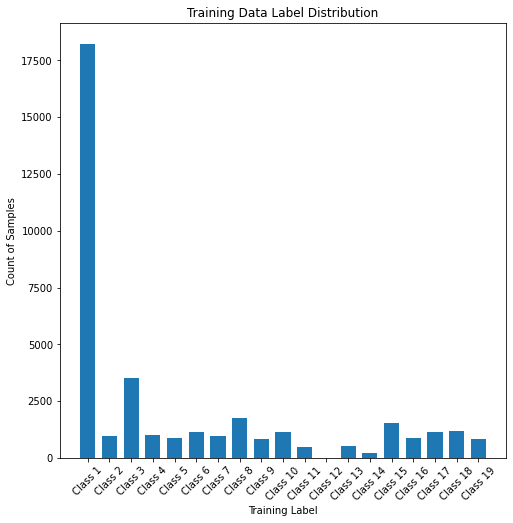

In [ ]:
%matplotlib inline
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12', 'Class 13', 'Class 14', 'Class 15', 
'Class 16', 'Class 17', 'Class 18','Class 19']
plt.rcParams['figure.figsize'] = [8, 8]
plt.title('Training Data Label Distribution')
plt.ylabel('Count of Samples')
plt.xlabel('Training Label')
plt.xticks(np.arange(0,19,1), class_labels, rotation=45)
plt.bar(np.arange(len(class_counts)),class_counts, width=0.7)


In [ ]:
def calc_label_weights(n_classes, samples_classes, pw=1):
    label_weightage = 1.0 / np.array(np.power(samples_classes, pw))
    label_weightage = label_weightage / np.sum(label_weightage) * n_classes
    return label_weightage



#### Display Sample Images after Pre-processing

index : 0
image label : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0.])


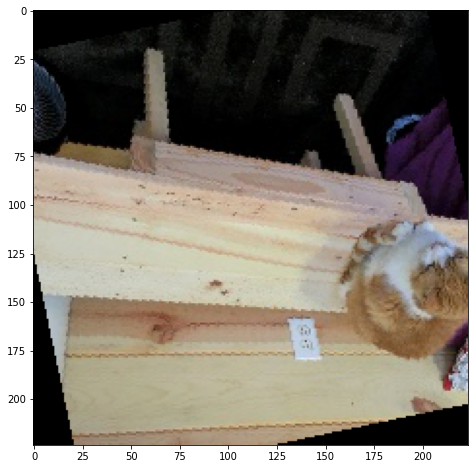

index : 1
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


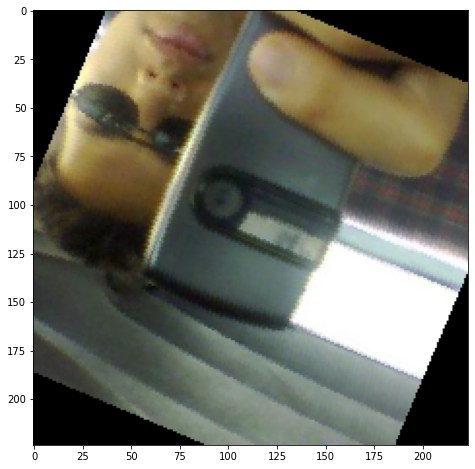

index : 2
image label : tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


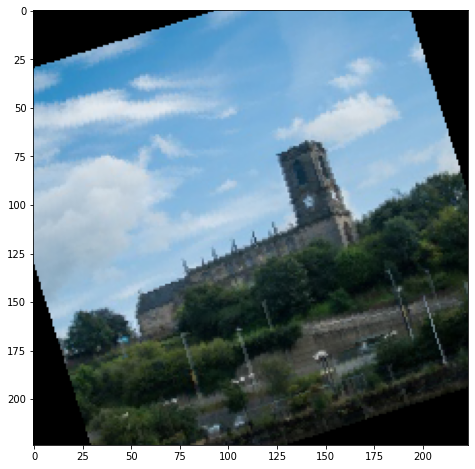

index : 3
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.])


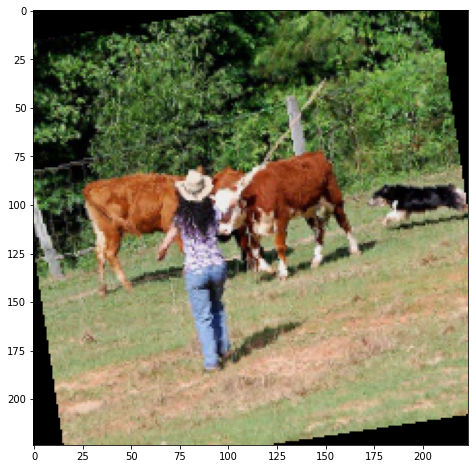

index : 4
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


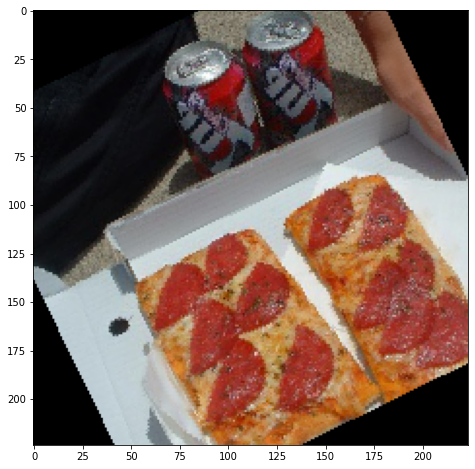

done!


In [ ]:
## Reconstruct some images -- note: images have been normalised 
for i in range(5):
    print('index : {}'.format(i))
    print('image label : {}'.format(labels[i]))
    npimg = images[i].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('done!')

## Modelling stage:

##### Pre-trained Resnext50_32X4d

In [ ]:
# Implement a simple NN for testing 

class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))



##### Removing gradients for re-training and ignoring pre-trained gradients

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Implement a simple NN for testing 
feature_extract = True

#### Create pre-trained DenseNet (121)

In [ ]:
# Implement a simple NN for testing 

class Dense161(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        densenet = models.densenet121(pretrained=True)
        densenet.classifier = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(in_features=densenet.classifier.in_features, out_features=n_classes)
        )
        self.base_model = densenet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

# model = Dense161(19).to(dev)

#### Create pre-trained ResNet50

In [ ]:
class Resnet50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        set_parameter_requires_grad(resnet, feature_extract)
        resnet.fc = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))
        # return self.base_model(x)

# Initialize Base Model
model = Resnet50(19).to(dev)


##### Set parameters to update

In [ ]:
params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer = optim.Adam(params_to_update, lr=0.001)

summary(model.cuda(), (1,3, 224, 224))

Params to learn:
	 base_model.fc.0.weight
	 base_model.fc.0.bias


Layer (type:depth-idx)                        Output Shape              Param #
Resnet50                                      --                        --
├─ResNet: 1-1                                 [1, 19]                   --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

In [ ]:
def accuracy(predicted, original):  
    """
    Calculates the number of labels correctly predicted for each image
    """
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

### Model Training with hypermarameters

In [ ]:
# https://pytorch.org/docs/stable/optim.html


# Switch model to the training mode
criterion = nn.BCEWithLogitsLoss(pos_weight=sss)


model.train()

no_epochs = 100
epoch_loss = []

## Perform training stage 
for epoch in range(no_epochs): 
    print(f'epoch {epoch + 1}')

    start = time.time()
    ep_loss = 0.0
    ep_acc = 0.0
    
    ## Enumerate through data
    for i, (inputs,labels) in enumerate(train_loader, 0):
        # Get the inputs
        inputs = inputs.to(dev)
        labels = labels.to(dev)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs.float(), labels.float())

        preds = outputs
        torch.cuda.empty_cache()
        ep_loss += loss
        ep_acc += accuracy(torch.round(preds).cpu(), labels.cpu())

        loss.backward()
        optimizer.step()
    
    print(f'Loss: {ep_loss/(i+1) :.3f}, Accuracy: {ep_acc/(i+1) :.3f}')
    print(f'time taken to run: {time.time() - start}')
    epoch_loss.append(round(ep_loss.item()/(i+1),2))

epoch 1
Loss: 1.392, Accuracy: 15.052
time taken to run: 120.51531386375427
epoch 2
Loss: 1.326, Accuracy: 15.694
time taken to run: 120.54413533210754
epoch 3
Loss: 1.315, Accuracy: 15.725
time taken to run: 119.57208490371704
epoch 4
Loss: 1.308, Accuracy: 15.778
time taken to run: 119.94130158424377
epoch 5
Loss: 1.301, Accuracy: 15.829
time taken to run: 120.03193783760071
epoch 6
Loss: 1.299, Accuracy: 15.825
time taken to run: 119.56634259223938
epoch 7
Loss: 1.297, Accuracy: 15.829
time taken to run: 120.25976324081421
epoch 8
Loss: 1.295, Accuracy: 15.874
time taken to run: 119.82085609436035
epoch 9
Loss: 1.292, Accuracy: 15.894
time taken to run: 118.54088425636292
epoch 10
Loss: 1.293, Accuracy: 15.852
time taken to run: 121.36406874656677
epoch 11
Loss: 1.290, Accuracy: 15.870
time taken to run: 119.8795554637909
epoch 12
Loss: 1.288, Accuracy: 15.908
time taken to run: 121.09932923316956
epoch 13
Loss: 1.288, Accuracy: 15.864
time taken to run: 121.17381930351257
epoch 14


##### Visualise Training Loss

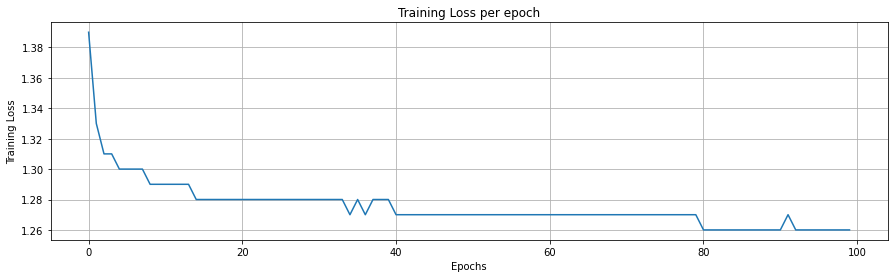

In [ ]:
plt.figure(figsize=(15,4))
plt.title('Training Loss per epoch')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.plot(epoch_loss)
plt.grid()

In [ ]:
torch.cuda.memory.empty_cache()

### Model Validation on validation set data

In [ ]:
import gc

model.eval()

epoch_loss = 0.0
epoch_accuracy = 0.0
pred_results = np.array(range(1,20)).reshape(1,19)
# target_results = np.arange(19).reshape(1,19)
target_results = np.array(range(1,20)).reshape(1,19)
print(target_results.shape, target_results)

for step, (inputs, label) in enumerate(validation_loader):
    # inputs = inputs.view(-1, 3*224*224)

    inputs = torch.Tensor.cpu(inputs).to(dev)
    label = torch.Tensor.cpu(label).to(dev)
    # print(inputs.shape)

    y_pred = model(inputs)
    preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
    preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()
    targets_np = torch.Tensor.cpu(label).detach().numpy()

    # preds = np.where(preds_np == 1)[1]
    # print(preds_np.shape, preds.shape, preds_np[0], preds_rounded.shape, preds_rounded[0])
    # acc = accuracy(preds_rounded.cpu(), label.cpu())
    pred_results = np.concatenate((pred_results, preds_np), axis=0)
    target_results = np.concatenate((target_results, targets_np), axis=0)

    # print('Predicted: \n', torch.round(y_pred))
    # print('True: \n', label)
    acc = accuracy(preds_rounded.cpu(), label.cpu())
    torch.cuda.empty_cache()
    
    epoch_loss += criterion(y_pred.float(), label.float())
    epoch_accuracy += acc

print(epoch_loss/(len(validation_loader)))
print(epoch_accuracy/(len(validation_loader)))
print(pred_results.shape, target_results.shape)

(1, 19) [[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
tensor(1.2906, device='cuda:0', grad_fn=<DivBackward0>)
15.776401068621814
(6000, 19) (6000, 19)


In [ ]:
class_names = np.array(list(range(1, 20)))

### Model evaluation
- Classification Report
- Confusion Matrix for all classes

In [ ]:
classes = [str(i).zfill(2) for i in range(1,20)]
print(class_names, classes)
print(classification_report(target_results[1:], pred_results[1:], target_names=classes , zero_division=1))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
              precision    recall  f1-score   support

          01       0.83      0.98      0.90      4557
          02       0.09      0.77      0.16       220
          03       0.32      0.78      0.46       860
          04       0.18      0.89      0.31       262
          05       0.40      0.91      0.55       236
          06       0.20      0.82      0.32       272
          07       0.21      0.92      0.34       250
          08       0.25      0.80      0.38       472
          09       0.16      0.79      0.26       206
          10       0.21      0.87      0.34       316
          11       0.08      0.79      0.15       108
          12       1.00      1.00      1.00         0
          13       0.08      0.77      0.14       105
          14       0.04      0.68      0.08        50
          15   

###### Confusion Matrix

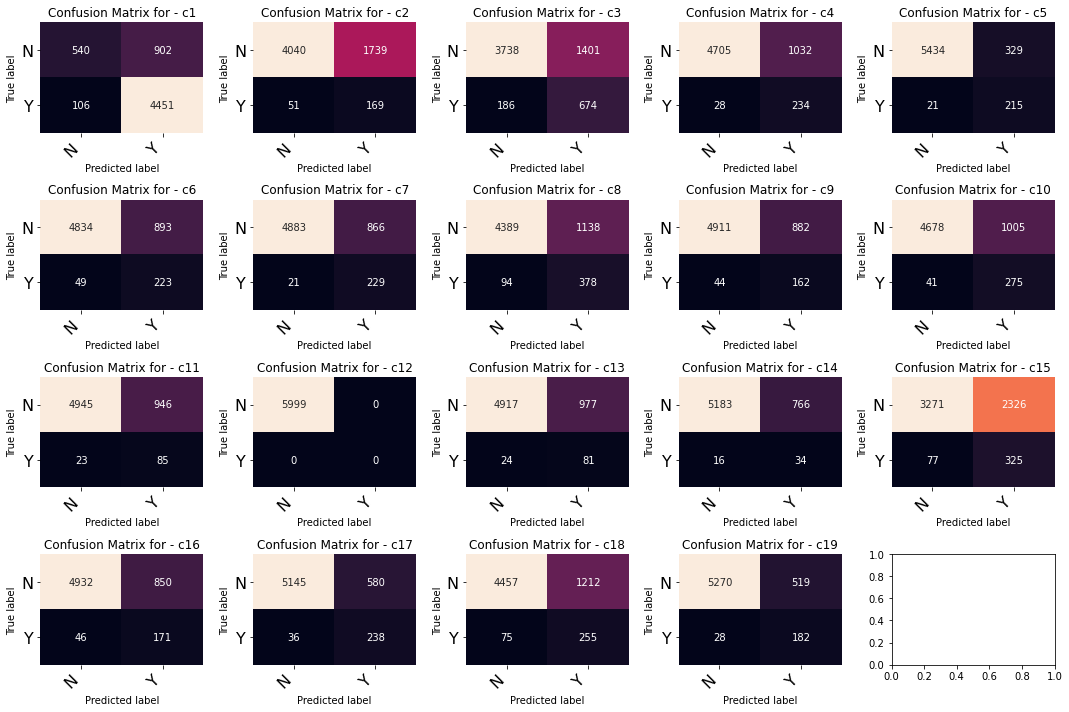

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, coverage_error
multi_matrix = multilabel_confusion_matrix(target_results[1:], pred_results[1:])


labels = ["".join("c" + str(i)) for i in range(1, 20)]

def display_heatmap(confusion_matrix, axes, class_labels, class_names, fontsize=16):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for - " + class_labels)


fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), multi_matrix, labels):
        display_heatmap(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

## Test Prediction
- Initialize test loader
- Run and save predictions

In [ ]:
test_dataset = load_test_data(data_path, "test.csv", transform=transform)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          shuffle = False, 
                                          batch_size = None
                                          )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                shuffle=False, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

test_images = next(iter(test_loader))

print('No. Test images loaded: ',len(test_loader)*batch_size)

No. Test images loaded:  10112


##### Test set - Predict and save results

In [ ]:
## Make test predictions
model.eval()
test_pred_results = np.array(range(1,20)).reshape(1,19)
images = []
predictions = []
cnt=0

for step, (test_inputs) in enumerate(test_loader):
    idx = step*batch_size
    images.append(test_dataset.annotations.ImageID[idx:(idx+batch_size)])
    test_inputs = torch.Tensor.cpu(test_inputs).to(dev)

    y_test = model(test_inputs)

    test_preds_rounded = torch.round(y_test) #anything greater than prob > 0.5 converted to predicted label
    test_preds_np = torch.Tensor.cpu(test_preds_rounded).detach().numpy()
    test_pred_results = np.concatenate((test_pred_results, test_preds_np), axis=0)


test_pred_results = test_pred_results[1:]
for result in test_pred_results:
    result_lb = class_names[result == 1.0] 
    preds_string = [str(int) for int in result_lb]
    predictions.append(' '.join(preds_string))


prediction_upload = pd.DataFrame(zip(test_dataset.annotations.ImageID, predictions), columns = ['ImageID', 'Labels'])
prediction_upload.to_csv(data_path + '/alexnet_test_predictions.csv', index = False)
prediction_upload.head()

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1 2 3 8 15
2,30002.jpg,1 2 10 15 18
3,30003.jpg,1 5 9 16 18 19
4,30004.jpg,1 2 3 4 11 13 15
